In [50]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import os 
import pandas as pd

def load_data(path):
    """Načte soubor databáze a vrátí vzorky signálu EKG a seznam polí"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0].flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    
    except Exception as e:
        print(f"Chyba při načítání dat: {e}")
        return None, None

def estimate_threshold(signal, perc=95):
    return np.percentile(signal, perc)

def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Odebere baseline wander pro lepší manipulaci s daty pomocí Fourierovy transformace
    k nalezení nízkofrekvenčních komponent a jejich odstranění."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1 / sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline

def find_Rpeaks(signal):
    """Najde R píky v EKG signálu s dynamicky se měnící velikostí okna.
    Vrátí seznam píků a odpovídajících časů."""
    threshold = estimate_threshold(signal)
    peaks = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(signal):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                is_peak = False
    return np.array(peaks)

def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    """Počítá počet R píků každých 15 sekund"""
    signal_duration = len(signal) / samp_rate
    window_duration = 15.0
    window_count = int(signal_duration / window_duration)

    r_peak_counts = [0] * window_count

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1

    return r_peak_counts

def plot_bpm_over_time(bpm_values, driver, window_duration=10.0):
    """Graf BPM"""
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v čase ' + driver)
    plt.xlabel('Minut')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()

[    14     39     65 ... 172375 172397 172418]


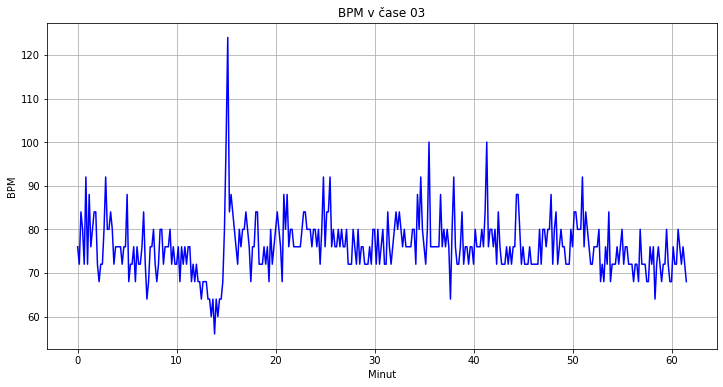

In [54]:
database = 'Database/drive03'
driver = database[-2:]
ECGnative, fields = load_data(database)
samp_rate = fields['fs']

ecg_data = np.array(ECGnative)
cutoff_frequency = 0.5

ecg_edit_fft = remove_baseline_wander_fft(ecg_data, samp_rate, cutoff_frequency=cutoff_frequency)
Rpeaks = find_Rpeaks(ecg_edit_fft)
print(Rpeaks)
r_peak_counts = [count* 4 for count in count_rpeaks_in_windows(ecg_edit_fft, Rpeaks, samp_rate)]

plot_bpm_over_time(r_peak_counts, driver)

In [38]:
def evaluate_detection(true_peaks, detected_peaks, correct_threshold=0.0001):
    correct = 0
    total = len(true_peaks)
    for true_peak in true_peaks:
        detected = False
        for detected_peak in detected_peaks:
            delta = (true_peak+1) / (detected_peak+1)
            deltap = np.abs(1-delta)
            if deltap < correct_threshold:
                detected = True
                break

        if detected:
            correct += 1

    return correct, total - correct, total, len(detected_peaks)

def test_file(file_path, sampfrom=0, nsamp=100000, correct_threshold=0.0001):
    signal, _ = wfdb.rdsamp(file_path, channels=None, sampfrom=sampfrom, sampto=sampfrom+nsamp)
    true_peaks = wfdb.rdann(file_path, extension="atr", sampfrom=sampfrom, sampto=sampfrom+nsamp).sample
    signal = signal[:, 0]
    detected_peaks = find_Rpeaks(signal)
    return evaluate_detection(true_peaks, detected_peaks, correct_threshold)

In [39]:
import os
import pandas as pd

success_count = 0
total_count = 0

data = []

for file in os.listdir("test"):
    if file[-3:] != "dat":
        continue
    
    file = file[:-4]
    correct, wrong, total, peaks = test_file("test/" + file)
    success_count += correct
    total_count += total

    success_rate = correct / total * 100

    data.append([file, correct, wrong, total, success_rate])

df = pd.DataFrame(data, columns=["File", "Correct", "Wrong", "Total", "Success rate"])
total_success_rate = success_count / total_count * 100

print("Test results:")
print(df)
print(f"Total success rate: {total_success_rate:.2f}%")

Test results:
     File  Correct  Wrong  Total  Success rate
0   16265     1141    176   1317     86.636295
1   16272      797    200    997     79.939819
2   16273     1006    237   1243     80.933226
3   16420      905    249   1154     78.422877
4   16483      930    241   1171     79.419300
5   16539     1028     67   1095     93.881279
6   16773      822    569   1391     59.094177
7   16786      754    210    964     78.215768
8   16795      756    303   1059     71.388102
9   17052      859    259   1118     76.833631
10  17453      930    104   1034     89.941973
11  18177     1214    279   1493     81.312793
12  18184      918    283   1201     76.436303
13  19088      977    404   1381     70.745836
14  19090     1034    114   1148     90.069686
15  19093      771    190    961     80.228928
16  19140      995    268   1263     78.780681
17  19830     1263    161   1424     88.693820
Total success rate: 79.85%
